In [2]:
import os
from PIL import Image

os.chdir("../../")

#### Setup and load images

In [2]:
# 1. Setup
assets_dir = 'data/Assets/'  # Path to assets folder
game_id = '0a22f881b77f00220f2034c21a18b854'      # A chosen game id folder
game_folder = os.path.join(assets_dir, game_id)

image_files = [f for f in os.listdir(game_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]


# 2. Load Images
images = []
for image_file in image_files:
    img_path = os.path.join(game_folder, image_file)
    images.append(Image.open(img_path))


#### Side by side image composition

In [3]:
# 3. Basic Composition: Side-by-Side (Example)
total_width = sum(img.width for img in images)
max_height = max(img.height for img in images)

new_image = Image.new('RGB', (total_width, max_height))

x_offset = 0
for img in images:
    new_image.paste(img, (x_offset, 0))
    x_offset += img.width

# 4. More Advanced Composition (Conceptual)

# - Resize images:
#   resized_img = img.resize((new_width, new_height))

# - Overlay images:
#   background = Image.open('background.jpg')
#   background.paste(img, (x_offset, y_offset), img)  # img has transparency

# - Add text:
#   from PIL import ImageDraw, ImageFont
#   draw = ImageDraw.Draw(new_image)
#   font = ImageFont.truetype("arial.ttf", 16)
#   draw.text((x, y), "Your Text", (255, 255, 255), font=font)

# 5. Save or Display
# new_image.save("composed_image.png")  # Save the result
# new_image.show()                     # Display the result


/home/hillary_kipkemoi/Automated-Storyboard-Synthesis-Digital-Advertising/.venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


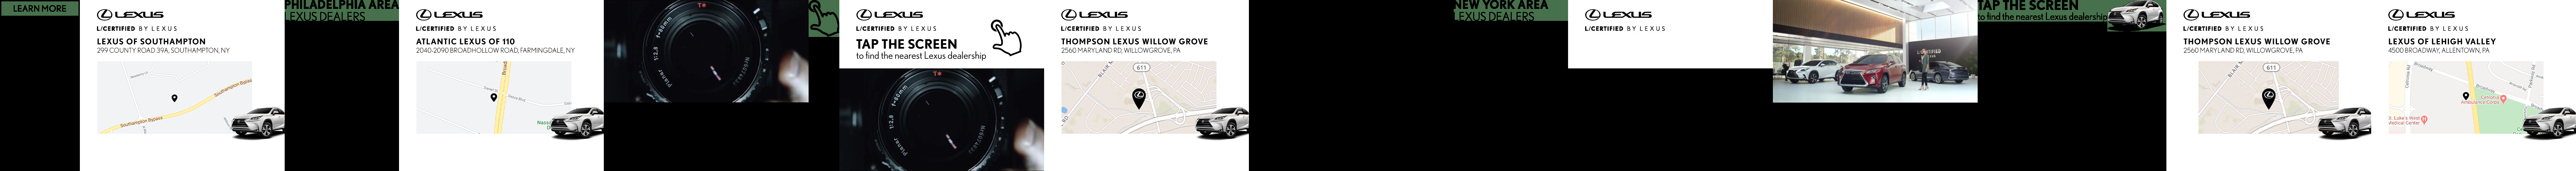

In [4]:
# Display the composed image
display(new_image)

### YOLO Image elements detection

In [7]:
from ultralytics import YOLO
from PIL import Image

model = YOLO('yolov8x.pt')  # Load the YOLOv8 model (ensure you have the correct path)
img_path = "data/Assets/0a22f881b77f00220f2034c21a18b854/_preview.png" #Example image path
results = model(img_path) 

for result in results:
    boxes = result.boxes  
    for box in boxes:
        # Class of object detected
        class_id = box.cls[0]  
        class_name = model.names[int(class_id)]

        # Coordinates of bounding box
        x1, y1, x2, y2 = box.xyxy[0]  
        print(f"Object: {class_name}, Coordinates: ({x1}, {y1}), ({x2}, {y2})")


image 1/1 /home/hillary_kipkemoi/Automated-Storyboard-Synthesis-Digital-Advertising/data/Assets/0a22f881b77f00220f2034c21a18b854/_preview.png: 544x640 1 clock, 3930.0ms
Speed: 3.8ms preprocess, 3930.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)
Object: clock, Coordinates: (110.55300903320312, 201.8790283203125), (506.8303527832031, 495.1152038574219)


### Detect the text from the image using pytesseract (OCR)

In [8]:
import pytesseract
from PIL import Image

def get_text_positions(image_path):
    """
    Extracts text elements and their positions from an image using OCR.
    """
    image = Image.open(image_path)
    data = pytesseract.image_to_data(image, output_type=pytesseract.Output.DICT)

    text_positions = {}
    for i in range(len(data['text'])):
        if int(data['conf'][i]) > 60:  # Confidence threshold for accurate detection
            text = data['text'][i]
            top_left = (data['left'][i], data['top'][i])
            bottom_right = (top_left[0] + data['width'][i], top_left[1] + data['height'][i])
            text_positions[text] = {'top_left': top_left, 'bottom_right': bottom_right}
    return text_positions

# Find text positions
text_positions = get_text_positions('data/Assets/0a22f881b77f00220f2034c21a18b854/engagement_instruction_1.png')  # Replace with the actual image name

print(text_positions)


{'TAP': {'top_left': (0, 1), 'bottom_right': (64, 28)}, 'THE': {'top_left': (75, 1), 'bottom_right': (140, 28)}, 'SCREEN': {'top_left': (152, 0), 'bottom_right': (293, 29)}, 'to': {'top_left': (0, 40), 'bottom_right': (21, 58)}, 'find': {'top_left': (27, 36), 'bottom_right': (65, 58)}, 'the': {'top_left': (73, 36), 'bottom_right': (106, 58)}, 'nearest': {'top_left': (114, 40), 'bottom_right': (192, 58)}, 'Lexus': {'top_left': (200, 36), 'bottom_right': (261, 58)}, 'dealership': {'top_left': (268, 36), 'bottom_right': (380, 63)}}


### Compose two images

In [7]:
def compose_images(image_paths, positions):
    # Load images
    images = [Image.open(path) for path in image_paths]

    # Determine canvas size (find the maximum width and height among all images)
    max_width = max(pos['bottom_right'][0] for pos in positions)
    max_height = max(pos['bottom_right'][1] for pos in positions)

    # Create a new blank image (canvas)
    composed_image = Image.new('RGB', (max_width, max_height))

    # Paste each image onto the canvas at the specified position
    for img, pos in zip(images, positions):
        composed_image.paste(img, pos['top_left'])

    return composed_image


In [8]:
from PIL import Image, ImageDraw, ImageFont

def compose_ad_frame(background_image_path, elements):
    """
    Composes an advertisement frame using a background image and element information.

    Args:
        background_image_path (str): The path to the background image file.
        elements (list): A list of dictionaries, each containing information about an element:
            - name (str): The name of the element.
            - image_path (str): The path to the element's image file.
            - position (tuple): The (x, y) coordinates of the top-left corner of the element.
            - size (tuple, optional): The (width, height) to resize the element to. If not provided, the original size is used.

    Returns:
        PIL.Image: The composed ad frame as a Pillow Image object.
    """
    
    # Load background image
    background = Image.open(background_image_path)

    # Create a new image with the same dimensions as the background
    frame = Image.new("RGB", background.size)

    # Get background image size
    with Image.open(background_image_path) as background:
        bg_width, bg_height = background.size

    # Paste the background image
    frame.paste(background, (0, 0))

    # Iterate over the elements and paste them onto the frame
    for element in elements:
        img = Image.open(element['image_path'])

        # Calculate scaling factor (example)
        if 'size' in element:
            scale_factor = min(element['size'][0] / img.width, element['size'][1] / img.height)
            new_size = (int(img.width * scale_factor), int(img.height * scale_factor))
            img = img.resize(new_size)

        # Dynamic positioning (example)
        if element['position'] == 'center':
            x = (bg_width - img.width) // 2
            y = (bg_height - img.height) // 2
            element['position'] = (x, y)

        # Handle Text Elements (Example)
        if element['name'].endswith('_text'):  # Check if element is text
            draw = ImageDraw.Draw(frame)
            font = ImageFont.truetype("arial.ttf", 16)  # Example font
            text_position = (element['position'][0], element['position'][1] + img.height + 5)  # Adjust position for text below image
            draw.text(text_position, element['name'].replace('_text', ''), (255, 255, 255), font=font)  # White text

    return frame


In [9]:
# Define elements with their positions (replace with actual paths and coordinates)
elements = [
    {'name': 'engagement_instruction_1.png', 'image_path': 'data/Assets/0a22f881b77f00220f2034c21a18b854/engagement_instruction_1.png', 'position': 'center'},
    # {'name': 'certified_text', 'image_path': 'certified_text.png', 'position': (90, 10)},
    # {'name': 'tap_screen_text', 'image_path': 'tap_screen.png', 'position': (200, 300), 'size': (150, 50)},
    # {'name': 'finger_icon', 'image_path': 'finger.png', 'position': (360, 310), 'size': (40, 40)}
    # # ... Add more elements
]

# Compose the frame
composed_frame = compose_ad_frame('data/Assets/0a22f881b77f00220f2034c21a18b854/header.jpg', elements) 
# If there's a video in one of the frames, consider using a frame extractor and include the extracted frame in elements.

# Save the image 
composed_frame.save('composed_ad.jpg') 


AttributeError: 'NoneType' object has no attribute 'seek'

### Resizing

In [10]:
from PIL import Image

def overlay_image_halfway(bottom_image_path, top_image_path, output_path):
    """
    Overlays the top image onto the bottom image, starting halfway down.

    Args:
        bottom_image_path (str): The path to the bottom image file.
        top_image_path (str): The path to the top image file.
        output_path (str): The path to save the composed image.
    """

    try:
        # Load the images
        bottom_img = Image.open(bottom_image_path)
        top_img = Image.open(top_image_path)
        
        # Get the dimensions of the bottom image
        bottom_width, bottom_height = bottom_img.size

        # Resize the top image to match the width of the bottom image, maintaining aspect ratio
        top_img_resized = top_img.resize((bottom_width, int(bottom_width * top_img.height / top_img.width)))

        # Calculate the position for pasting the top image (halfway down the bottom image)
        paste_position = (0, bottom_height // 2)

        # Create a new image with the combined height
        new_height = bottom_height + (top_img_resized.height // 2)  # Add half the height of the resized top image
        composed_img = Image.new("RGB", (bottom_width, new_height))

        # Paste the bottom image onto the new image
        composed_img.paste(bottom_img, (0, 0))

        # Paste the top image onto the new image at the calculated position
        composed_img.paste(top_img_resized, paste_position)

        # Save the composed image
        composed_img.save(output_path)

        print("Composed image saved successfully!")

    except (FileNotFoundError, PIL.UnidentifiedImageError) as e:
        print(f"Error: {e}")


In [11]:
bottom_image_path = "data/Assets/0a22f881b77f00220f2034c21a18b854/header.jpg"
top_image_path = "data/Assets/0a22f881b77f00220f2034c21a18b854/engagement_instruction_1.png"
output_path = "composed_image.png"
overlay_image_halfway(bottom_image_path, top_image_path, output_path)

Composed image saved successfully!


/home/hillary_kipkemoi/Automated-Storyboard-Synthesis-Digital-Advertising/.venv/lib/python3.8/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [12]:
from PIL import Image

def overlay_image_halfway(bottom_image_path, top_image_path, output_path):
    """
    Overlays the top image onto the bottom image, starting halfway down without resizing.

    Args:
        bottom_image_path (str): The path to the bottom image file.
        top_image_path (str): The path to the top image file.
        output_path (str): The path to save the composed image.
    """
    try:
        # Load the images
        bottom_img = Image.open(bottom_image_path)
        top_img = Image.open(top_image_path)

        # Get the dimensions of the bottom image
        bottom_width, bottom_height = bottom_img.size
        top_width, top_height = top_img.size

        # Calculate the position for pasting the top image (halfway down the bottom image)
        paste_position = (0, bottom_height // 2)

        # Create a new image with the combined width and adjusted height (to prevent overflow)
        new_width = max(bottom_width, top_width)
        new_height = bottom_height + (top_height // 2) 
        composed_img = Image.new("RGB", (new_width, new_height), (255, 255, 255))  # Create a white background

        # Paste the bottom image onto the new image
        composed_img.paste(bottom_img, (0, 0))

        # Paste the top image onto the new image at the calculated position
        composed_img.paste(top_img, paste_position)

        # Save the composed image
        composed_img.save(output_path)

        print("Composed image saved successfully!")

    except (FileNotFoundError, PIL.UnidentifiedImageError) as e:
        print(f"Error: {e}")


In [13]:
bottom_image_path = "data/Assets/0a22f881b77f00220f2034c21a18b854/header.jpg"
top_image_path = "data/Assets/0a22f881b77f00220f2034c21a18b854/engagement_instruction_1.png"
output_path = "composed_image.png"
overlay_image_halfway(bottom_image_path, top_image_path, output_path)

Composed image saved successfully!


### Compose image with background blending

In [20]:
from PIL import Image

def overlay_image_halfway(bottom_image_path, top_image_path, output_path):
    """
    Overlays the top image onto the bottom image, starting halfway down.
    Blends images if the top image has transparency.

    Args:
        bottom_image_path (str): The path to the bottom image file.
        top_image_path (str): The path to the top image file.
        output_path (str): The path to save the composed image.
    """

    try:
        # Load the images
        bottom_img = Image.open(bottom_image_path).convert("RGBA")  # Convert bottom_img to RGBA
        top_img = Image.open(top_image_path).convert("RGBA")  # Convert top_img to RGBA

        # Get the dimensions of the images
        bottom_width, bottom_height = bottom_img.size
        top_width, top_height = top_img.size

        # Calculate the position for pasting the top image (halfway down the bottom image)
        paste_position = (0, bottom_height // 2)

        # Create a new image with the combined width and adjusted height, in RGBA mode
        new_width = max(bottom_width, top_width)
        new_height = bottom_height + (top_height // 2)
        composed_img = Image.new("RGBA", (new_width, new_height), (255, 255, 255, 255)) # Create a transparent background

        # Paste the bottom image onto the new image
        composed_img.paste(bottom_img, (0, 0))

        # Blend the top image onto the composed image using alpha composite (for transparency)
        composed_img.alpha_composite(top_img, paste_position)

        # Convert to RGB before saving if you don't want to keep transparency
        composed_img = composed_img.convert("RGB")  

        # Save the composed image
        composed_img.save(output_path)

        print("Composed image saved successfully!")

    except (FileNotFoundError, UnidentifiedImageError) as e:
        print(f"Error: {e}")


In [21]:
bottom_image_path = "data/Assets/0a22f881b77f00220f2034c21a18b854/header.jpg"
top_image_path = "data/Assets/0a22f881b77f00220f2034c21a18b854/engagement_instruction_1.png"
output_path = "composed_image.png"
overlay_image_halfway(bottom_image_path, top_image_path, output_path)

Composed image saved successfully!


In [22]:
from PIL import Image

def overlay_image_halfway(bottom_image_path, top_image_path, output_path):
    """
    Overlays the top image onto the bottom image, starting halfway down and centered horizontally.
    Blends images if the top image has transparency.

    Args:
        bottom_image_path (str): The path to the bottom image file.
        top_image_path (str): The path to the top image file.
        output_path (str): The path to save the composed image.
    """

    try:
        # Load the images
        bottom_img = Image.open(bottom_image_path).convert("RGBA")
        top_img = Image.open(top_image_path).convert("RGBA")

        # Get the dimensions of the images
        bottom_width, bottom_height = bottom_img.size
        top_width, top_height = top_img.size

        # Calculate the position for pasting the top image (halfway down and centered horizontally)
        x_offset = (bottom_width - top_width) // 2
        paste_position = (x_offset, bottom_height // 2)

        # Create a new image with the combined width and adjusted height, in RGBA mode
        new_width = max(bottom_width, top_width)
        new_height = bottom_height + (top_height // 2)
        composed_img = Image.new("RGBA", (new_width, new_height), (255, 255, 255, 255))

        # Paste the bottom image onto the new image
        composed_img.paste(bottom_img, (0, 0))

        # Blend the top image onto the composed image using alpha composite (for transparency)
        composed_img.alpha_composite(top_img, paste_position)

        # Convert to RGB before saving if you don't want to keep transparency
        composed_img = composed_img.convert("RGB")

        # Save the composed image
        composed_img.save(output_path)

        print("Composed image saved successfully!")

    except (FileNotFoundError, PIL.UnidentifiedImageError) as e:
        print(f"Error: {e}")


In [23]:
bottom_image_path = "data/Assets/0a22f881b77f00220f2034c21a18b854/header.jpg"
top_image_path = "data/Assets/0a22f881b77f00220f2034c21a18b854/engagement_instruction_1.png"
output_path = "composed_image.png"
overlay_image_halfway(bottom_image_path, top_image_path, output_path)

Composed image saved successfully!


#### Combine the top and the bottom image

In [25]:
from PIL import Image

# Combine the header and the bottom part of the image
def compose_with_thumbnail(composed_image_path, thumbnail_path, output_path):
    """
    Combines a composed image with a thumbnail, placing the thumbnail at the bottom.

    Args:
        composed_image_path (str): The path to the composed image file.
        thumbnail_path (str): The path to the thumbnail image file.
        output_path (str): The path to save the final composed image.
    """

    try:
        # Load the images
        composed_img = Image.open(composed_image_path).convert("RGBA")
        thumbnail_img = Image.open(thumbnail_path).convert("RGBA")

        # Get the dimensions of the images
        composed_width, composed_height = composed_img.size
        thumbnail_width, thumbnail_height = thumbnail_img.size

        # Resize the thumbnail to match the width of the composed image, maintaining aspect ratio
        thumbnail_img_resized = thumbnail_img.resize((composed_width, int(composed_width * thumbnail_height / thumbnail_width)))

        # Calculate the position for pasting the thumbnail (at the bottom)
        paste_position = (0, composed_height)

        # Create a new image with the combined height
        new_height = composed_height + thumbnail_img_resized.height
        final_img = Image.new("RGBA", (composed_width, new_height), (255, 255, 255, 255))

        # Paste the composed image onto the final image
        final_img.paste(composed_img, (0, 0))

        # Paste the thumbnail onto the final image at the calculated position
        final_img.alpha_composite(thumbnail_img_resized, paste_position)

        # Convert to RGB before saving if you don't want to keep transparency
        final_img = final_img.convert("RGB")

        # Save the final composed image
        final_img.save(output_path)

        print("Final composed image saved successfully!")

    except (FileNotFoundError, PIL.UnidentifiedImageError) as e:
        print(f"Error: {e}")


In [26]:
composed_image_path = "composed_image.png"  # Path to the image created by overlay_image_halfway
thumbnail_path = "data/Assets/0a22f881b77f00220f2034c21a18b854/thumbnail.jpg"        # Path to your thumbnail image
output_path = "final_composed_image.jpg"
compose_with_thumbnail(composed_image_path, thumbnail_path, output_path)


Final composed image saved successfully!


#### Draw bounding boxes on the image to enclose the text

In [9]:
import cv2
from matplotlib import pyplot as plt

# Load the image
image_path = 'data/Assets/0a22f881b77f00220f2034c21a18b854/_preview.png'
img = cv2.imread(image_path)

# Coordinates of the bounding boxes (you provided these earlier)
logo_coords = [(30, 10), (280, 62)]  # (x1, y1), (x2, y2)
certified_coords = [(30, 72), (283, 102)]

# Draw the bounding boxes
cv2.rectangle(img, logo_coords[0], logo_coords[1], (0, 0, 255), 2)  # Red color, thickness 2
cv2.rectangle(img, certified_coords[0], certified_coords[1], (0, 0, 255), 2)

# (Optional) Save the image with bounding boxes
cv2.imwrite('header_with_boxes.jpg', img) 


True

In [10]:
import cv2
import pytesseract

# Configure pytesseract path to where the tesseract executable is located
pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'  # Update this path based on your Tesseract installation

def detect_text_and_draw_boxes(image_path):
    # Load the image
    img = cv2.imread(image_path)
    
    # Convert the image to RGB (pytesseract expects RGB)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Use pytesseract to detect text and their boxes
    custom_config = r'--oem 3 --psm 6'
    details = pytesseract.image_to_data(img_rgb, output_type=pytesseract.Output.DICT, config=custom_config)
    
    # Loop over each text detection
    for i in range(len(details['text'])):
        if int(details['conf'][i]) > 60:  # Confidence threshold
            (x, y, w, h) = (details['left'][i], details['top'][i], details['width'][i], details['height'][i])
            img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    # Display the image
    # cv2.imshow('Image with Text Boxes', img)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    cv2.imwrite('preview_with_boxes.jpg', img) 

# Example usage
image_path = 'data/Assets/0a22f881b77f00220f2034c21a18b854/_preview.png'
detect_text_and_draw_boxes(image_path)